# Squidpy analysis of Vizgen data

## 1. Imports

In [39]:
import numpy as np
import pandas as pd
from pathlib import Path
import shutil
import os
from matplotlib import pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq
import geopandas as gpd

## 2. Setup

In [40]:
os.chdir("/beegfs/scratch/ric.sessa/kubacki.michal/SRF_Linda/SRF_Spatial_segmentation")

## 3. Load Data

In [41]:
data_dir = "./2task_cellpose2_p30-E165_R1_roi_analysis_parallel"
# Create a directory to save the results
results_dir = os.path.join(data_dir, "analysis_results")
os.makedirs(results_dir, exist_ok=True)

In [42]:
adata = sq.read.vizgen(
    path=data_dir,
    counts_file="cell_by_gene.csv",
    meta_file="cell_metadata.csv",
)
print("Data loaded:")
print(adata)

Data loaded:
AnnData object with n_obs × n_vars = 20167 × 960
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity'
    uns: 'spatial'
    obsm: 'blank_genes', 'spatial'


### Get Library ID

In [43]:
# Get the library id from the anndata object
try:
    library_id = list(adata.uns['spatial'].keys())[0]
    print(f"Using library_id: {library_id}")
except (KeyError, IndexError):
    print("Could not automatically determine library_id. Spatial plots may fail.")
    library_id = None

Using library_id: library


### Load Cell Boundaries

In [44]:
# Load the cell boundaries and add them to the anndata object
segmentation_path = os.path.join(data_dir, "cellpose2_mosaic_space.parquet")
boundaries = gpd.read_parquet(segmentation_path)
adata.uns['spatial'][library_id]['segmentations'] = boundaries
print("Successfully loaded cell boundaries.")

Successfully loaded cell boundaries.


## 4. Pre-processing and QC

We perform standard pre-processing and quality control steps.

Saved QC metrics distribution plot.


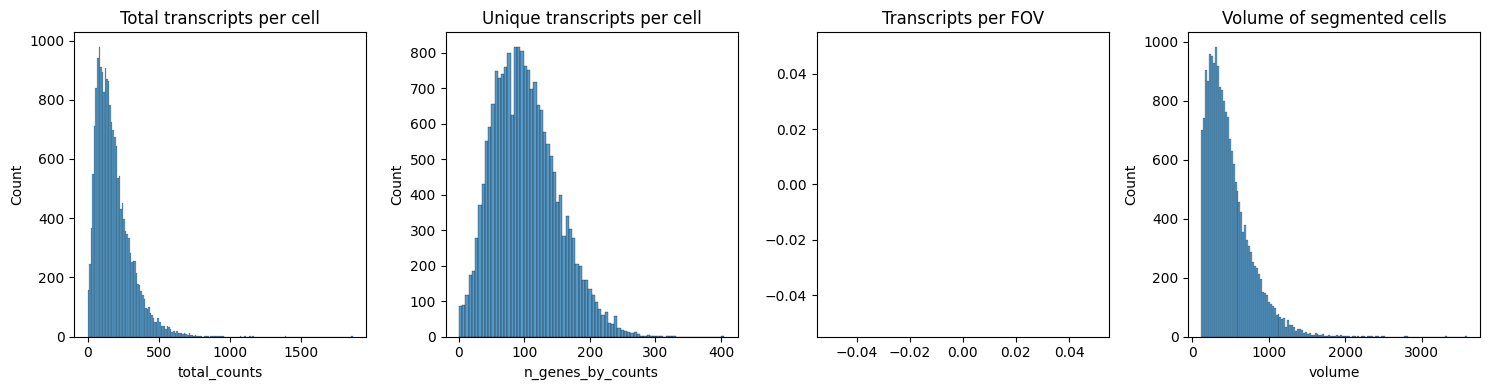

In [45]:
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, percent_top=(50, 100, 200, 300), inplace=True)

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
axs[0].set_title("Total transcripts per cell")
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, ax=axs[1])
axs[1].set_title("Unique transcripts per cell")
sns.histplot(adata.obs.groupby("fov").sum()["total_counts"], kde=False, ax=axs[2])
axs[2].set_title("Transcripts per FOV")
sns.histplot(adata.obs["volume"], kde=False, ax=axs[3])
axs[3].set_title("Volume of segmented cells")
fig.tight_layout()
plt.savefig(os.path.join(results_dir, "qc_metrics_distribution.png"))
print("Saved QC metrics distribution plot.")

### Filtering

In [46]:
# Filter cells with low expression and genes that are expressed in too few cells.
print(f"Number of cells before filtering: {adata.n_obs}")
sc.pp.filter_cells(adata, min_counts=50)
print(f"Number of cells after filtering by counts: {adata.n_obs}")

print(f"Number of genes before filtering: {adata.n_vars}")
sc.pp.filter_genes(adata, min_cells=10)
print(f"Number of genes after filtering by cells: {adata.n_vars}")

Number of cells before filtering: 20167
Number of cells after filtering by counts: 18499
Number of genes before filtering: 960
Number of genes after filtering by cells: 960


### Normalization and Scaling

In [47]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
print("Normalization and scaling complete.")

Normalization and scaling complete.


## 5. Dimensionality Reduction and Clustering

In [48]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1.0)
print("Dimensionality reduction and clustering complete.")

Dimensionality reduction and clustering complete.


## 6. Visualization

### UMAP

In [49]:
sc.pl.umap(adata, color=["leiden"], size=10, show=False, save="_leiden.png")
# Move the file to the results directory
Path("figures/umap_leiden.png").rename(f"{results_dir}/umap_leiden.png")
shutil.rmtree("figures")
print("Saved UMAP plot.")

/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Saved UMAP plot.


### Spatial Scatter

Saved spatial scatter plot.


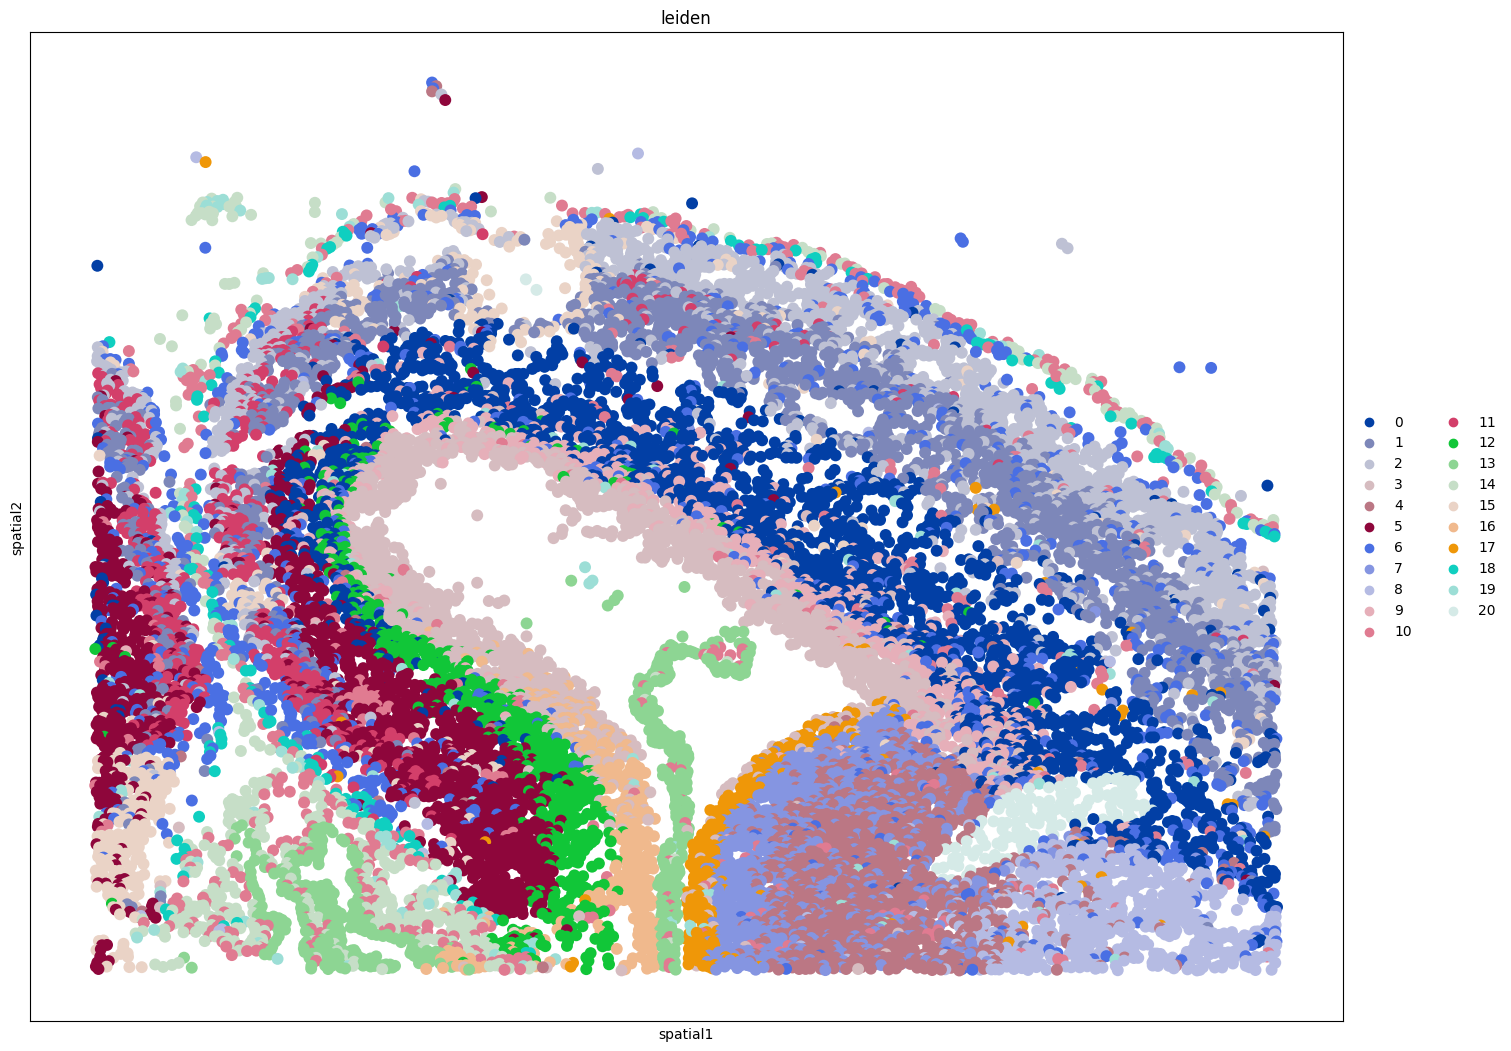

In [50]:
sq.pl.spatial_scatter(
    adata,
    library_id=library_id,
    color="leiden",
    img=False,
    figsize=(15, 15),
    size=10,
    save="spatial_leiden.png"
)
# Move the file to the results directory
if os.path.exists("figures/spatial_leiden.png"):
    Path("figures/spatial_leiden.png").rename(f"{results_dir}/spatial_leiden.png")
    shutil.rmtree("figures")
    print("Saved spatial scatter plot.")
else:
    print("Could not save spatial scatter plot.")

## 7. Spatial Analysis
Spatial organization of the clustered cells.

### Neighborhood Enrichment
Clusters that are spatially co-enriched.

  0%|          | 0/1000 [00:00<?, ?/s]

Saved neighborhood enrichment plot.


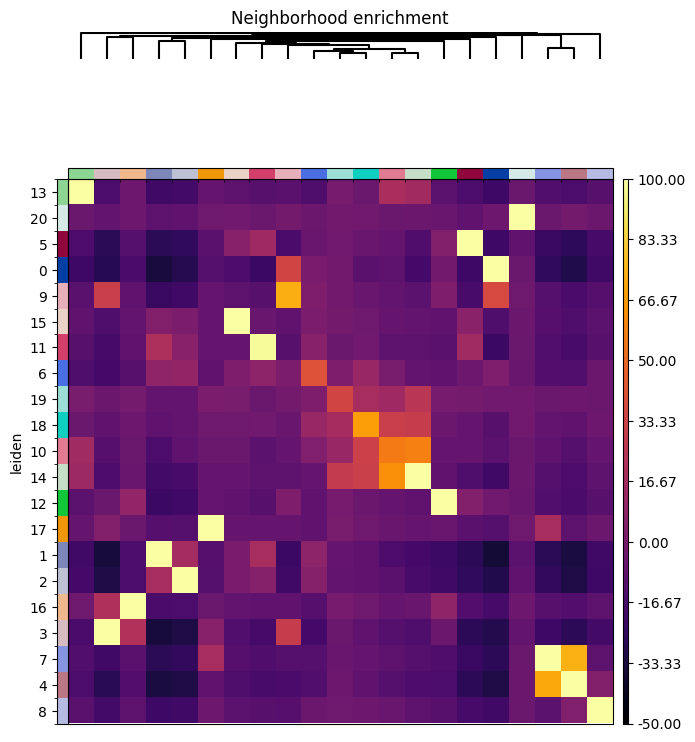

In [51]:
sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial")
sq.gr.nhood_enrichment(adata, cluster_key="leiden")
sq.pl.nhood_enrichment(
    adata,
    cluster_key="leiden",
    method="average",
    cmap="inferno",
    vmin=-50,
    vmax=100,
    figsize=(7, 7),
    save="_enrichment.png",
)
Path("figures/_enrichment.png").rename(f"{results_dir}/neighborhood_enrichment.png")
shutil.rmtree("figures")
print("Saved neighborhood enrichment plot.")

### Spatial Autocorrelation (Moran's I)
Identify genes that show a non-random spatial distribution.

In [52]:
sq.gr.spatial_autocorr(adata, mode="moran")
print("Top 10 spatially autocorrelated genes:")
print(adata.uns["moranI"].head(10))

Top 10 spatially autocorrelated genes:
               I  pval_norm  var_norm  pval_norm_fdr_bh
Clic6   0.861749        0.0  0.000017               0.0
Cdh3    0.658100        0.0  0.000017               0.0
Foxj1   0.609015        0.0  0.000017               0.0
Satb2   0.608815        0.0  0.000017               0.0
Col3a1  0.591207        0.0  0.000017               0.0
Gria2   0.582812        0.0  0.000017               0.0
Meis2   0.578882        0.0  0.000017               0.0
Zbtb20  0.577356        0.0  0.000017               0.0
Vim     0.555489        0.0  0.000017               0.0
Igfbp2  0.551087        0.0  0.000017               0.0


### Visualize top spatially autocorrelated genes

Saved top spatially autocorrelated genes plot.

Analysis complete. Results are in the 'analysis_results' directory.


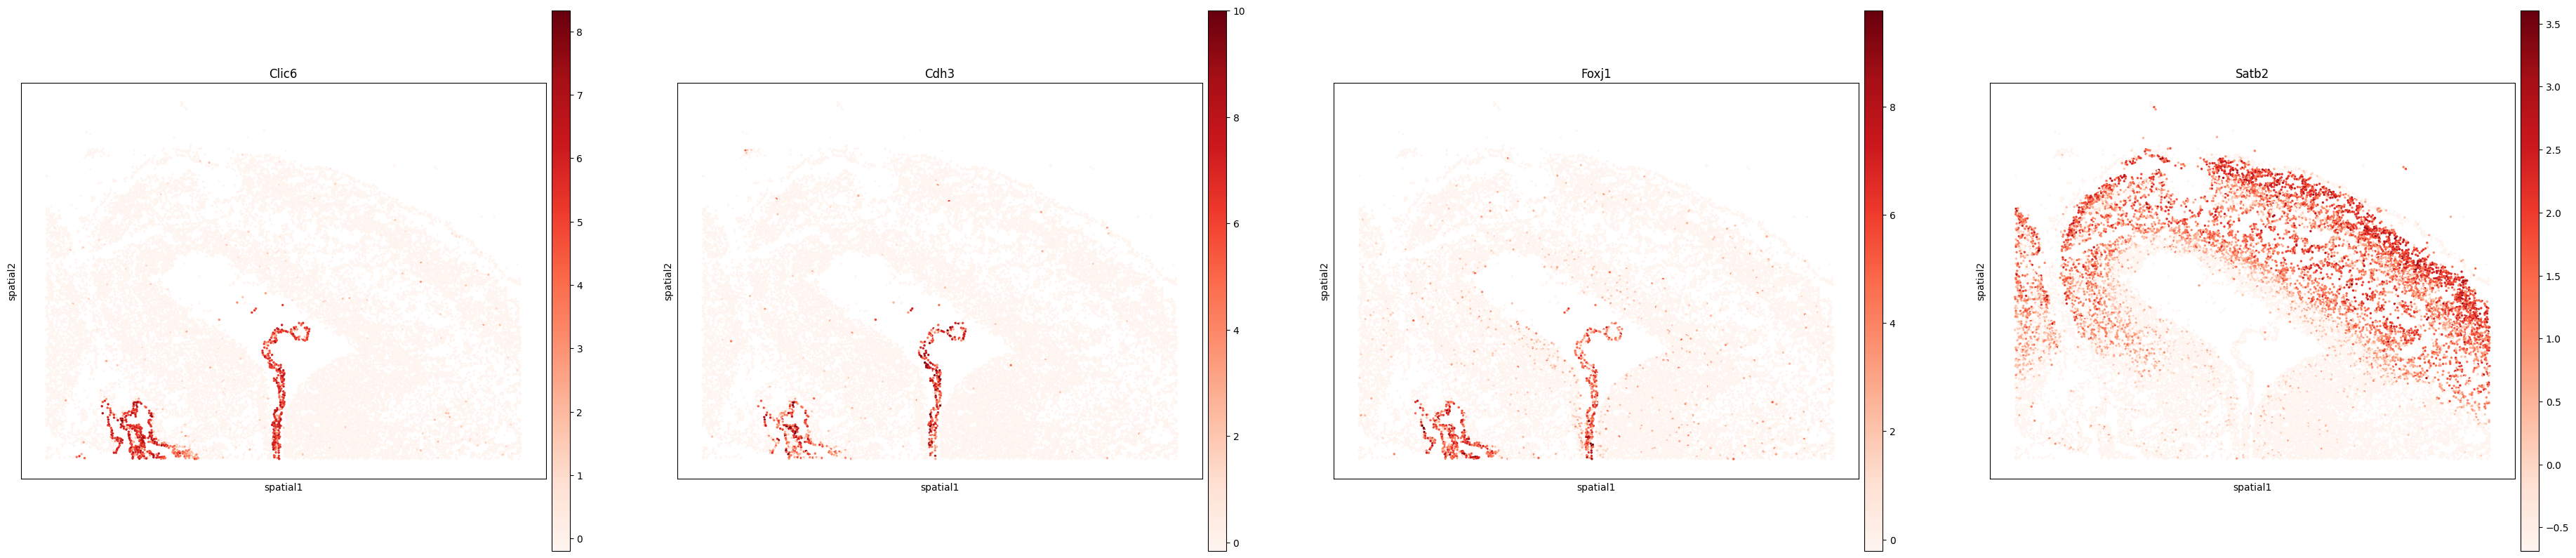

In [53]:
top_autocorr = adata.uns["moranI"]["I"].sort_values(ascending=False).head(4).index.tolist()
sq.pl.spatial_scatter(
    adata,
    library_id=library_id,
    color=top_autocorr,
    size=5,
    cmap="Reds",
    img=False,
    figsize=(10, 10),
    save="spatial_top_autocorr.png"
)
Path("./figures/spatial_top_autocorr.png").rename(f"{results_dir}/spatial_top_autocorr.png")
os.rmdir("figures")
print("Saved top spatially autocorrelated genes plot.")

print("\nAnalysis complete. Results are in the 'analysis_results' directory.")

In [54]:
# Save the AnnData object, but first remove GeoDataFrame from spatial metadata
# as it cannot be serialized to HDF5 format
print("Preparing to save AnnData object...")

# Store the boundaries separately if they exist
boundaries_to_save = None
if library_id and 'segmentations' in adata.uns['spatial'][library_id]:
    boundaries_to_save = adata.uns['spatial'][library_id]['segmentations']
    # Remove the GeoDataFrame from spatial metadata before saving
    del adata.uns['spatial'][library_id]['segmentations']
    print("Removed GeoDataFrame from spatial metadata for HDF5 compatibility.")

# Save the AnnData object
adata.write(os.path.join(results_dir, "squidpy_adata_1.h5ad"))
print("Successfully saved AnnData object.")

# Save the boundaries separately as parquet file
if boundaries_to_save is not None:
    boundaries_path = os.path.join(results_dir, "cell_boundaries.parquet")
    boundaries_to_save.to_parquet(boundaries_path)
    print(f"Saved cell boundaries separately to: {boundaries_path}")
    
    # Restore the boundaries to the AnnData object for continued use in this session
    adata.uns['spatial'][library_id]['segmentations'] = boundaries_to_save
    print("Restored boundaries to AnnData object for current session.")

Preparing to save AnnData object...
Removed GeoDataFrame from spatial metadata for HDF5 compatibility.
Successfully saved AnnData object.
Saved cell boundaries separately to: ./2task_cellpose2_p30-E165_R1_roi_analysis_parallel/analysis_results/cell_boundaries.parquet
Restored boundaries to AnnData object for current session.


## 8. Loading Saved Data Back

This section demonstrates how to load the saved AnnData object and cell boundaries back into memory.

In [55]:
# Example: How to load the saved data back
print("=" * 50)
print("EXAMPLE: Loading saved data back")
print("=" * 50)

# Load the AnnData object
print("Loading AnnData object...")
adata_loaded = sc.read_h5ad(os.path.join(results_dir, "squidpy_adata_1.h5ad"))
print(f"Loaded AnnData object: {adata_loaded}")

# Get the library_id from the loaded data
try:
    library_id_loaded = list(adata_loaded.uns['spatial'].keys())[0]
    print(f"Library ID: {library_id_loaded}")
except (KeyError, IndexError):
    print("No spatial information found in loaded data.")
    library_id_loaded = None

# Load the cell boundaries back
boundaries_path = os.path.join(results_dir, "cell_boundaries.parquet")
if os.path.exists(boundaries_path):
    print("Loading cell boundaries...")
    boundaries_loaded = gpd.read_parquet(boundaries_path)
    print(f"Loaded boundaries: {boundaries_loaded.shape[0]} cells")
    
    # Add the boundaries back to the spatial metadata
    if library_id_loaded:
        adata_loaded.uns['spatial'][library_id_loaded]['segmentations'] = boundaries_loaded
        print("Successfully restored cell boundaries to AnnData object.")
    
    # Verify the boundaries are properly loaded
    print(f"Boundaries columns: {list(boundaries_loaded.columns)}")
    print(f"Boundaries geometry type: {boundaries_loaded.geometry.geom_type.iloc[0]}")
else:
    print(f"Cell boundaries file not found at: {boundaries_path}")

print("\nData loading complete! The loaded AnnData object now contains:")
print(f"- {adata_loaded.n_obs} cells")
print(f"- {adata_loaded.n_vars} genes")
print(f"- Spatial information: {'Yes' if 'spatial' in adata_loaded.uns else 'No'}")
if library_id_loaded and 'segmentations' in adata_loaded.uns['spatial'][library_id_loaded]:
    print(f"- Cell boundaries: Yes ({adata_loaded.uns['spatial'][library_id_loaded]['segmentations'].shape[0]} cells)")
else:
    print("- Cell boundaries: No")

EXAMPLE: Loading saved data back
Loading AnnData object...
Loaded AnnData object: AnnData object with n_obs × n_vars = 18499 × 960
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes', 'n_counts', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'leiden_nhood_enrichment', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'blank_genes', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'
Library ID: library
Loading cell boundaries...
Loaded b